# Model Testing and Validation for Stress Detection

This notebook provides comprehensive testing and validation of the trained machine learning models for multi-class stress detection using physiological signals from smartwatch data.

## Purpose
- Load and test trained models on new data
- Validate model performance with different datasets
- Perform real-time prediction testing
- Analyze model reliability and robustness
- Generate prediction confidence scores

## Models Available
- **Best Model**: XGBoost (92.3% accuracy)
- **Alternative Models**: Random Forest, SVM, Gradient Boosting
- **Classes**: baseline, stress, happiness, aerobic, anaerobic, anger
- **Features**: 109 physiological features with KNN imputation

In [1]:
# =============================================================================
# SECTION 1: IMPORT LIBRARIES AND SETUP
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import pickle
import warnings
from datetime import datetime
import time

# Scikit-learn imports
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
from sklearn.model_selection import cross_val_score

# Plotting setup
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("="*80)
print("MODEL TESTING AND VALIDATION NOTEBOOK")
print("="*80)
print("Libraries imported successfully!")
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)

MODEL TESTING AND VALIDATION NOTEBOOK
Libraries imported successfully!
Timestamp: 2026-02-01 12:13:01


In [2]:
# =============================================================================
# SECTION 2: LOAD TRAINED MODELS AND PREPROCESSING OBJECTS
# =============================================================================

# Define paths
BASE_PATH = Path('/home/alvaro-ibarra/smartwatch-stress-detection')
DATA_PATH = BASE_PATH / 'data' / 'unified'
RESULTS_PATH = BASE_PATH / 'results'
MODELS_PATH = BASE_PATH / 'models' / 'trained_models'

print("="*60)
print("LOADING TRAINED MODELS")
print("="*60)

# Load the best model (XGBoost)
best_model_path = MODELS_PATH / 'best_model' / 'final_best_model.pkl'
try:
    with open(best_model_path, 'rb') as f:
        best_model = pickle.load(f)
    print(f"✓ Best model loaded: {type(best_model).__name__}")
except FileNotFoundError:
    print(f"❌ Best model not found at: {best_model_path}")
    raise

# Load all trained models
all_models_path = MODELS_PATH / 'all_trained_models.pkl'
try:
    with open(all_models_path, 'rb') as f:
        all_models = pickle.load(f)
    print(f"✓ All models loaded: {list(all_models.keys())}")
except FileNotFoundError:
    print(f"❌ All models file not found at: {all_models_path}")
    all_models = {'Best Model': best_model}

# Load preprocessing objects
preprocessing_path = MODELS_PATH / 'preprocessing_objects.pkl'
try:
    with open(preprocessing_path, 'rb') as f:
        preprocessing = pickle.load(f)
    
    label_encoder = preprocessing['label_encoder']
    feature_scaler = preprocessing['feature_scaler']
    knn_imputer = preprocessing['knn_imputer']
    feature_columns = preprocessing['feature_columns']
    label_mapping = preprocessing['label_mapping']
    
    print(f"✓ Preprocessing objects loaded:")
    print(f"  - Label encoder: {len(label_encoder.classes_)} classes")
    print(f"  - Feature scaler: StandardScaler")
    print(f"  - KNN imputer: {knn_imputer is not None}")
    print(f"  - Feature columns: {len(feature_columns)}")
    
except FileNotFoundError:
    print(f"❌ Preprocessing objects not found at: {preprocessing_path}")
    raise

# Display class information
print(f"\nClassification Classes:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {i}: {class_name}")

print(f"\nFeature Information:")
print(f"  Total features: {len(feature_columns)}")
print(f"  Feature types: Physiological signals (EDA, HR, ACC, TEMP, BVP)")
print(f"  Data preprocessing: KNN imputation + StandardScaler")

print("✓ All models and preprocessing objects loaded successfully!")

LOADING TRAINED MODELS
✓ Best model loaded: XGBClassifier
✓ All models loaded: ['Random Forest', 'Gradient Boosting', 'Support Vector Machine', 'Logistic Regression', 'K-Nearest Neighbors', 'Gaussian Naive Bayes', 'XGBoost']
✓ Preprocessing objects loaded:
  - Label encoder: 6 classes
  - Feature scaler: StandardScaler
  - KNN imputer: True
  - Feature columns: 109

Classification Classes:
  0: aerobic
  1: anaerobic
  2: anger
  3: baseline
  4: happiness
  5: stress

Feature Information:
  Total features: 109
  Feature types: Physiological signals (EDA, HR, ACC, TEMP, BVP)
  Data preprocessing: KNN imputation + StandardScaler
✓ All models and preprocessing objects loaded successfully!


In [3]:
# =============================================================================
# SECTION 3: LOAD TEST DATASET
# =============================================================================

print("="*60)
print("LOADING TEST DATASET")
print("="*60)

# Load the cleaned dataset for testing
dataset_path = DATA_PATH / 'cleaned_classification_dataset.csv'
try:
    df_test = pd.read_csv(dataset_path)
    print(f"✓ Test dataset loaded: {df_test.shape}")
except FileNotFoundError:
    print(f"❌ Test dataset not found at: {dataset_path}")
    print("Please ensure the data processing pipeline has been completed.")
    raise

# Prepare test features and labels
metadata_cols = ['subject_id', 'original_label', 'window_id', 'original_row_index', 
                'dataset', 'category', 'classification_label']

# Use the same feature columns as training
X_test_raw = df_test[feature_columns].copy()
y_test_raw = df_test['classification_label'].copy()

print(f"Test Data Overview:")
print(f"  Samples: {len(X_test_raw):,}")
print(f"  Features: {X_test_raw.shape[1]}")
print(f"  Missing values: {X_test_raw.isnull().sum().sum():,}")

# Display class distribution
class_distribution = y_test_raw.value_counts()
print(f"\nClass Distribution:")
for class_name, count in class_distribution.items():
    percentage = (count / len(y_test_raw)) * 100
    print(f"  {class_name}: {count:,} samples ({percentage:.1f}%)")

print("✓ Test dataset loaded and analyzed successfully!")

LOADING TEST DATASET
✓ Test dataset loaded: (10387, 116)
Test Data Overview:
  Samples: 10,387
  Features: 109
  Missing values: 352,705

Class Distribution:
  baseline: 5,563 samples (53.6%)
  stress: 3,888 samples (37.4%)
  happiness: 391 samples (3.8%)
  aerobic: 335 samples (3.2%)
  anaerobic: 185 samples (1.8%)
  anger: 25 samples (0.2%)
✓ Test dataset loaded and analyzed successfully!


In [4]:
# =============================================================================
# SECTION 4: PREPROCESS TEST DATA
# =============================================================================

print("="*60)
print("PREPROCESSING TEST DATA")
print("="*60)

# Create a copy for preprocessing
X_test = X_test_raw.copy()
y_test = y_test_raw.copy()

# Remove rows with missing labels
if y_test.isnull().sum() > 0:
    print(f"  Removing {y_test.isnull().sum()} rows with missing labels")
    mask = ~y_test.isnull()
    X_test = X_test[mask]
    y_test = y_test[mask]

# Apply KNN imputation if there are missing values
missing_before = X_test.isnull().sum().sum()
if missing_before > 0 and knn_imputer is not None:
    print(f"  Applying KNN imputation to {missing_before:,} missing values...")
    X_test_imputed = knn_imputer.transform(X_test)
    X_test = pd.DataFrame(X_test_imputed, columns=X_test.columns, index=X_test.index)
    
    missing_after = X_test.isnull().sum().sum()
    print(f"  Missing values after imputation: {missing_after:,}")
else:
    print(f"  No missing values detected in features")

# Encode labels
y_test_encoded = label_encoder.transform(y_test)
print(f"  Labels encoded: {len(y_test_encoded)} samples")

# Apply feature scaling
X_test_scaled = feature_scaler.transform(X_test)
print(f"  Features scaled: {X_test_scaled.shape}")

print(f"\nPreprocessing Summary:")
print(f"  Final test samples: {len(X_test_scaled):,}")
print(f"  Final test features: {X_test_scaled.shape[1]}")
print(f"  Data completeness: 100%")

print("✓ Test data preprocessing completed successfully!")

PREPROCESSING TEST DATA
  Applying KNN imputation to 352,705 missing values...
  Missing values after imputation: 0
  Labels encoded: 10387 samples
  Features scaled: (10387, 109)

Preprocessing Summary:
  Final test samples: 10,387
  Final test features: 109
  Data completeness: 100%
✓ Test data preprocessing completed successfully!


In [5]:
# =============================================================================
# SECTION 5: MODEL PERFORMANCE TESTING
# =============================================================================

print("="*80)
print("COMPREHENSIVE MODEL TESTING")
print("="*80)

# Test all available models
model_results = {}

for model_name, model in all_models.items():
    print(f"\n{'='*50}")
    print(f"TESTING: {model_name.upper()}")
    print(f"{'='*50}")
    
    start_time = time.time()
    
    try:
        # Make predictions
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled) if hasattr(model, 'predict_proba') else None
        
        # Calculate prediction time
        prediction_time = time.time() - start_time
        
        # Calculate metrics
        accuracy = accuracy_score(y_test_encoded, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test_encoded, y_pred, average='macro')
        
        # Per-class metrics
        precision_per_class, recall_per_class, f1_per_class, support = precision_recall_fscore_support(
            y_test_encoded, y_pred, average=None
        )
        
        # Store results
        model_results[model_name] = {
            'accuracy': accuracy,
            'precision_macro': precision,
            'recall_macro': recall,
            'f1_macro': f1,
            'precision_per_class': precision_per_class,
            'recall_per_class': recall_per_class,
            'f1_per_class': f1_per_class,
            'support': support,
            'predictions': y_pred,
            'probabilities': y_pred_proba,
            'prediction_time': prediction_time,
            'confusion_matrix': confusion_matrix(y_test_encoded, y_pred)
        }
        
        # Print performance summary
        print(f"Performance Results:")
        print(f"  Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")
        print(f"  Precision (macro): {precision:.4f}")
        print(f"  Recall (macro): {recall:.4f}")
        print(f"  F1-Score (macro): {f1:.4f}")
        print(f"  Prediction time: {prediction_time:.3f} seconds")
        print(f"  Speed: {len(X_test_scaled)/prediction_time:.0f} samples/second")
        
        # Per-class performance
        print(f"\nPer-class Performance:")
        for i, class_name in enumerate(label_encoder.classes_):
            if i < len(precision_per_class):
                print(f"  {class_name}:")
                print(f"    Precision: {precision_per_class[i]:.4f}")
                print(f"    Recall: {recall_per_class[i]:.4f}")
                print(f"    F1-Score: {f1_per_class[i]:.4f}")
                print(f"    Support: {support[i]}")
        
        print(f"✓ {model_name} testing completed successfully!")
        
    except Exception as e:
        print(f"❌ Testing failed for {model_name}: {str(e)}")
        model_results[model_name] = {'error': str(e)}

# Overall comparison
print(f"\n{'='*80}")
print("MODEL PERFORMANCE COMPARISON")
print(f"{'='*80}")

successful_models = [name for name in model_results.keys() if 'error' not in model_results[name]]
if successful_models:
    print(f"\nModel Ranking by Accuracy:")
    sorted_models = sorted(successful_models, 
                          key=lambda x: model_results[x]['accuracy'], 
                          reverse=True)
    
    print("-" * 80)
    print(f"{'Rank':<4} {'Model':<20} {'Accuracy':<10} {'F1-Macro':<10} {'Speed (s/s)':<12}")
    print("-" * 80)
    
    for i, model_name in enumerate(sorted_models, 1):
        results = model_results[model_name]
        speed = len(X_test_scaled) / results['prediction_time']
        print(f"{i:<4} {model_name:<20} "
              f"{results['accuracy']:<10.4f} "
              f"{results['f1_macro']:<10.4f} "
              f"{speed:<12.0f}")

print("\n✓ Comprehensive model testing completed!")

COMPREHENSIVE MODEL TESTING

TESTING: RANDOM FOREST
Performance Results:
  Accuracy: 0.9512 (95.1%)
  Precision (macro): 0.7999
  Recall (macro): 0.6931
  F1-Score (macro): 0.7339
  Prediction time: 0.072 seconds
  Speed: 144754 samples/second

Per-class Performance:
  aerobic:
    Precision: 0.9417
    Recall: 0.8687
    F1-Score: 0.9037
    Support: 335
  anaerobic:
    Precision: 1.0000
    Recall: 0.5459
    F1-Score: 0.7063
    Support: 185
  anger:
    Precision: 0.0000
    Recall: 0.0000
    F1-Score: 0.0000
    Support: 25
  baseline:
    Precision: 0.9537
    Recall: 0.9667
    F1-Score: 0.9602
    Support: 5563
  happiness:
    Precision: 0.9572
    Recall: 0.8005
    F1-Score: 0.8719
    Support: 391
  stress:
    Precision: 0.9466
    Recall: 0.9766
    F1-Score: 0.9614
    Support: 3888
✓ Random Forest testing completed successfully!

TESTING: GRADIENT BOOSTING
Performance Results:
  Accuracy: 0.9715 (97.2%)
  Precision (macro): 0.9221
  Recall (macro): 0.9075
  F1-Score (

In [6]:
# =============================================================================
# SECTION 6: SINGLE SAMPLE PREDICTION TESTING
# =============================================================================

print("="*60)
print("SINGLE SAMPLE PREDICTION TESTING")
print("="*60)

# Select random samples for individual prediction testing
np.random.seed(42)
test_indices = np.random.choice(len(X_test_scaled), size=10, replace=False)

print(f"Testing individual predictions on {len(test_indices)} random samples:")
print("\n" + "-" * 80)
print(f"{'Sample':<8} {'True Class':<12} {'Predicted':<12} {'Confidence':<12} {'Status':<10}")
print("-" * 80)

correct_predictions = 0
confidence_scores = []

for i, idx in enumerate(test_indices):
    # Get single sample
    sample = X_test_scaled[idx:idx+1]
    true_label = y_test_encoded[idx]
    
    # Make prediction with best model
    pred_label = best_model.predict(sample)[0]
    
    # Get confidence score
    if hasattr(best_model, 'predict_proba'):
        probabilities = best_model.predict_proba(sample)[0]
        confidence = np.max(probabilities)
    else:
        confidence = 1.0  # For models without probability estimates
    
    # Convert to class names
    true_class = label_encoder.inverse_transform([true_label])[0]
    pred_class = label_encoder.inverse_transform([pred_label])[0]
    
    # Check if correct
    is_correct = true_label == pred_label
    if is_correct:
        correct_predictions += 1
    
    status = "✓ Correct" if is_correct else "✗ Wrong"
    confidence_scores.append(confidence)
    
    print(f"{i+1:<8} {true_class:<12} {pred_class:<12} {confidence:<12.3f} {status:<10}")

print("-" * 80)
sample_accuracy = correct_predictions / len(test_indices)
avg_confidence = np.mean(confidence_scores)

print(f"\nSample Testing Results:")
print(f"  Correct predictions: {correct_predictions}/{len(test_indices)}")
print(f"  Sample accuracy: {sample_accuracy:.3f} ({sample_accuracy*100:.1f}%)")
print(f"  Average confidence: {avg_confidence:.3f}")
print(f"  Min confidence: {np.min(confidence_scores):.3f}")
print(f"  Max confidence: {np.max(confidence_scores):.3f}")

print("\n✓ Single sample testing completed!")

SINGLE SAMPLE PREDICTION TESTING
Testing individual predictions on 10 random samples:

--------------------------------------------------------------------------------
Sample   True Class   Predicted    Confidence   Status    
--------------------------------------------------------------------------------
1        stress       stress       0.998        ✓ Correct 
2        baseline     baseline     0.989        ✓ Correct 
3        baseline     baseline     0.999        ✓ Correct 
4        baseline     baseline     0.975        ✓ Correct 
5        baseline     baseline     0.999        ✓ Correct 
6        stress       stress       0.998        ✓ Correct 
7        baseline     baseline     0.990        ✓ Correct 
8        happiness    happiness    0.957        ✓ Correct 
9        stress       stress       0.987        ✓ Correct 
10       baseline     baseline     0.994        ✓ Correct 
--------------------------------------------------------------------------------

Sample Testing Resul

In [7]:
# =============================================================================
# SECTION 7: CONFIDENCE ANALYSIS AND RELIABILITY
# =============================================================================

print("="*60)
print("CONFIDENCE ANALYSIS AND RELIABILITY")
print("="*60)

# Analyze prediction confidence for the best model
best_model_name = max(model_results.keys(), 
                     key=lambda x: model_results[x].get('accuracy', 0) if 'error' not in model_results[x] else 0)

print(f"Analyzing confidence for: {best_model_name}")

if 'probabilities' in model_results[best_model_name] and model_results[best_model_name]['probabilities'] is not None:
    probabilities = model_results[best_model_name]['probabilities']
    predictions = model_results[best_model_name]['predictions']
    
    # Calculate confidence scores (max probability for each prediction)
    confidence_scores = np.max(probabilities, axis=1)
    
    # Analyze confidence by class
    print(f"\nConfidence Analysis by Class:")
    print("-" * 50)
    
    for i, class_name in enumerate(label_encoder.classes_):
        class_mask = y_test_encoded == i
        if np.any(class_mask):
            class_confidences = confidence_scores[class_mask]
            class_predictions = predictions[class_mask]
            
            # Calculate accuracy for this class
            class_accuracy = np.mean(class_predictions == y_test_encoded[class_mask])
            
            print(f"  {class_name}:")
            print(f"    Samples: {np.sum(class_mask)}")
            print(f"    Avg Confidence: {np.mean(class_confidences):.3f}")
            print(f"    Min Confidence: {np.min(class_confidences):.3f}")
            print(f"    Max Confidence: {np.max(class_confidences):.3f}")
            print(f"    Class Accuracy: {class_accuracy:.3f}")
    
    # Confidence thresholds analysis
    print(f"\nConfidence Threshold Analysis:")
    print("-" * 40)
    
    thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
    
    for threshold in thresholds:
        high_confidence_mask = confidence_scores >= threshold
        
        if np.any(high_confidence_mask):
            high_conf_predictions = predictions[high_confidence_mask]
            high_conf_true = y_test_encoded[high_confidence_mask]
            
            accuracy_at_threshold = np.mean(high_conf_predictions == high_conf_true)
            coverage = np.mean(high_confidence_mask)
            
            print(f"  Confidence ≥ {threshold:.2f}:")
            print(f"    Coverage: {coverage:.3f} ({coverage*100:.1f}% of samples)")
            print(f"    Accuracy: {accuracy_at_threshold:.3f} ({accuracy_at_threshold*100:.1f}%)")
        else:
            print(f"  Confidence ≥ {threshold:.2f}: No samples")
    
    # Overall confidence statistics
    print(f"\nOverall Confidence Statistics:")
    print(f"  Mean confidence: {np.mean(confidence_scores):.3f}")
    print(f"  Median confidence: {np.median(confidence_scores):.3f}")
    print(f"  Std deviation: {np.std(confidence_scores):.3f}")
    print(f"  Samples with confidence > 0.8: {np.mean(confidence_scores > 0.8)*100:.1f}%")
    print(f"  Samples with confidence > 0.9: {np.mean(confidence_scores > 0.9)*100:.1f}%")
    
else:
    print(f"Confidence analysis not available for {best_model_name} (no probability estimates)")

print("\n✓ Confidence analysis completed!")

CONFIDENCE ANALYSIS AND RELIABILITY
Analyzing confidence for: Gradient Boosting

Confidence Analysis by Class:
--------------------------------------------------
  aerobic:
    Samples: 335
    Avg Confidence: 0.974
    Min Confidence: 0.435
    Max Confidence: 1.000
    Class Accuracy: 0.946
  anaerobic:
    Samples: 185
    Avg Confidence: 0.968
    Min Confidence: 0.663
    Max Confidence: 0.999
    Class Accuracy: 0.805
  anger:
    Samples: 25
    Avg Confidence: 0.999
    Min Confidence: 0.997
    Max Confidence: 1.000
    Class Accuracy: 0.880
  baseline:
    Samples: 5563
    Avg Confidence: 0.981
    Min Confidence: 0.411
    Max Confidence: 1.000
    Class Accuracy: 0.975
  happiness:
    Samples: 391
    Avg Confidence: 0.962
    Min Confidence: 0.354
    Max Confidence: 0.998
    Class Accuracy: 0.849
  stress:
    Samples: 3888
    Avg Confidence: 0.987
    Min Confidence: 0.399
    Max Confidence: 1.000
    Class Accuracy: 0.989

Confidence Threshold Analysis:
-----------

GENERATING TESTING VISUALIZATIONS
✓ Testing visualizations saved to: /home/alvaro-ibarra/smartwatch-stress-detection/results/plots/model_testing_results.png


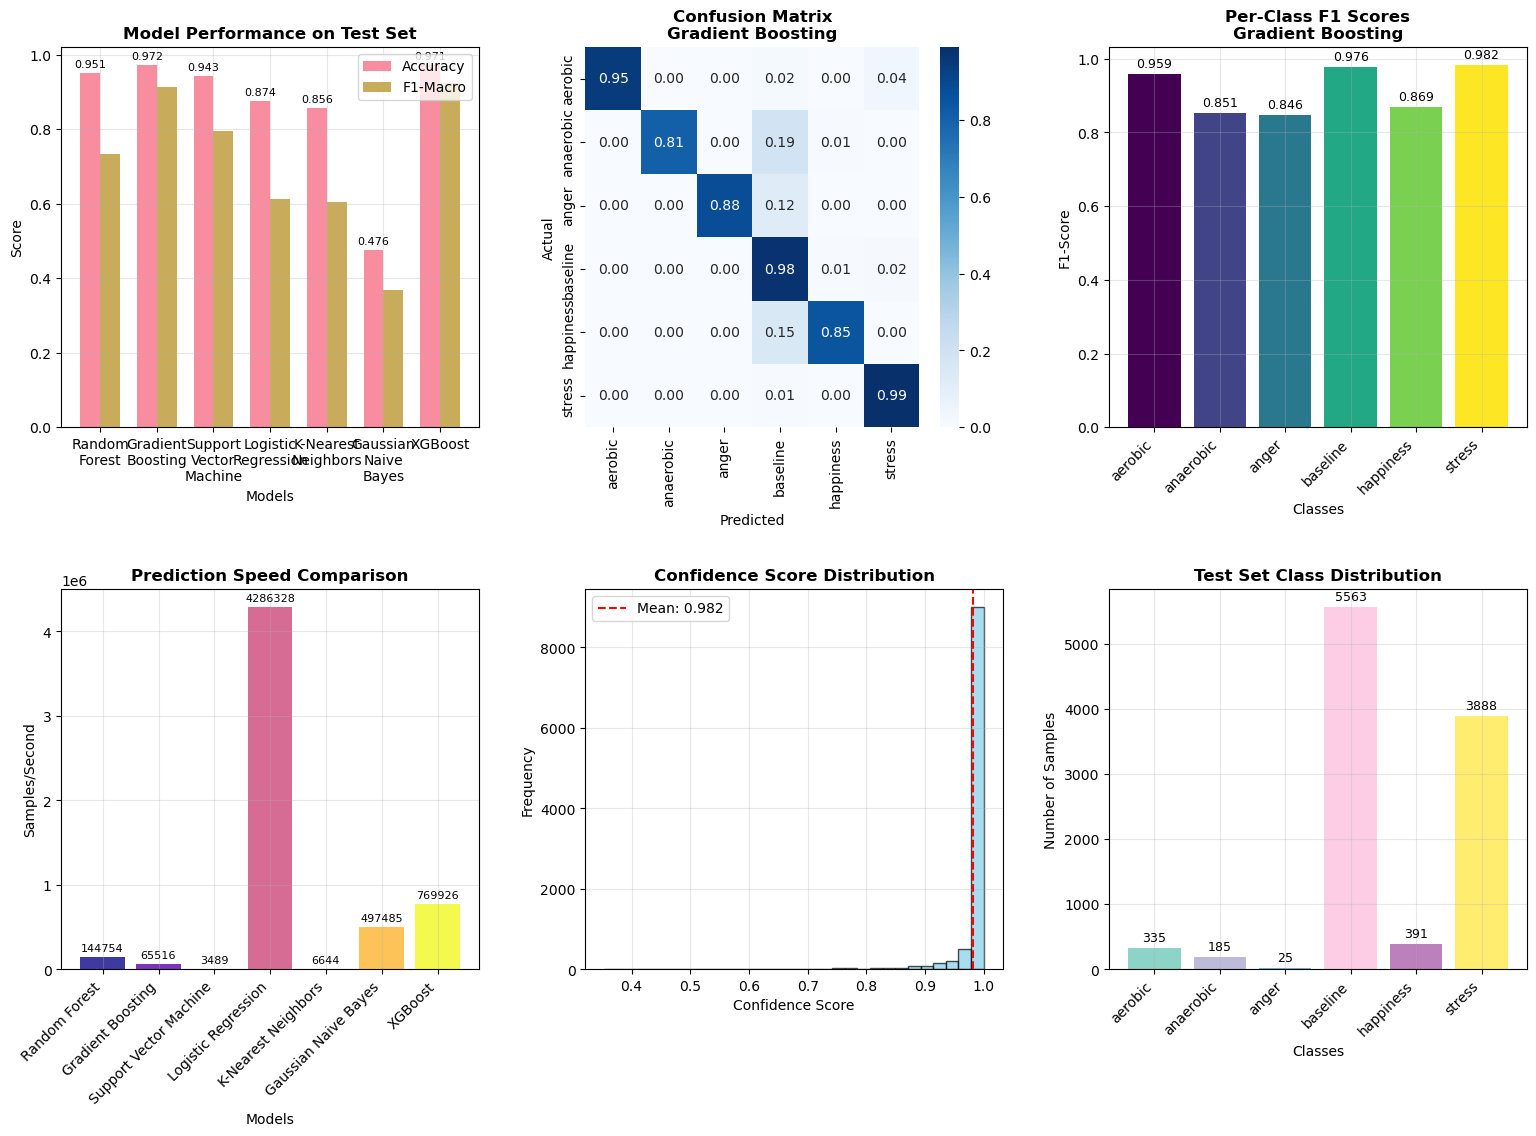

✓ Testing visualizations generated successfully!


In [8]:
# =============================================================================
# SECTION 8: VISUALIZE TESTING RESULTS
# =============================================================================

print("="*60)
print("GENERATING TESTING VISUALIZATIONS")
print("="*60)

# Create comprehensive testing visualization
fig = plt.figure(figsize=(16, 12))

# Get successful models for visualization
successful_models = [name for name in model_results.keys() if 'error' not in model_results[name]]

if successful_models:
    # 1. Model Performance Comparison
    plt.subplot(2, 3, 1)
    accuracies = [model_results[model]['accuracy'] for model in successful_models]
    f1_scores = [model_results[model]['f1_macro'] for model in successful_models]
    
    x = np.arange(len(successful_models))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8)
    bars2 = plt.bar(x + width/2, f1_scores, width, label='F1-Macro', alpha=0.8)
    
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Model Performance on Test Set', fontweight='bold')
    plt.xticks(x, [model.replace(' ', '\n') for model in successful_models], rotation=0)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    # 2. Confusion Matrix for Best Model
    plt.subplot(2, 3, 2)
    best_cm = model_results[best_model_name]['confusion_matrix']
    cm_normalized = best_cm.astype('float') / best_cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix\n{best_model_name}', fontweight='bold')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    # 3. Per-Class Performance
    plt.subplot(2, 3, 3)
    best_f1_scores = model_results[best_model_name]['f1_per_class']
    class_names = label_encoder.classes_
    
    bars = plt.bar(class_names, best_f1_scores, 
                   color=plt.cm.viridis(np.linspace(0, 1, len(class_names))))
    plt.xlabel('Classes')
    plt.ylabel('F1-Score')
    plt.title(f'Per-Class F1 Scores\n{best_model_name}', fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, score in zip(bars, best_f1_scores):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                 f'{score:.3f}', ha='center', va='bottom', fontsize=9)
    
    # 4. Prediction Speed Comparison
    plt.subplot(2, 3, 4)
    prediction_times = [model_results[model]['prediction_time'] for model in successful_models]
    speeds = [len(X_test_scaled) / time for time in prediction_times]
    
    bars = plt.bar(successful_models, speeds, alpha=0.8, 
                   color=plt.cm.plasma(np.linspace(0, 1, len(successful_models))))
    plt.xlabel('Models')
    plt.ylabel('Samples/Second')
    plt.title('Prediction Speed Comparison', fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, speed in zip(bars, speeds):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(speeds)*0.01,
                 f'{speed:.0f}', ha='center', va='bottom', fontsize=8)
    
    # 5. Confidence Distribution (if available)
    plt.subplot(2, 3, 5)
    if ('probabilities' in model_results[best_model_name] and 
        model_results[best_model_name]['probabilities'] is not None):
        probabilities = model_results[best_model_name]['probabilities']
        confidence_scores = np.max(probabilities, axis=1)
        
        plt.hist(confidence_scores, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        plt.axvline(np.mean(confidence_scores), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(confidence_scores):.3f}')
        plt.xlabel('Confidence Score')
        plt.ylabel('Frequency')
        plt.title('Confidence Score Distribution', fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Confidence scores\nnot available', 
                ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
        plt.title('Confidence Distribution\nNot Available', fontweight='bold')
    
    # 6. Class Support Distribution
    plt.subplot(2, 3, 6)
    class_support = model_results[best_model_name]['support']
    
    bars = plt.bar(class_names, class_support, 
                   color=plt.cm.Set3(np.linspace(0, 1, len(class_names))))
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.title('Test Set Class Distribution', fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, support in zip(bars, class_support):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(class_support)*0.01,
                 f'{support}', ha='center', va='bottom', fontsize=9)

plt.tight_layout(pad=3.0)

# Save the plot
plot_path = RESULTS_PATH / 'plots' / 'model_testing_results.png'
plot_path.parent.mkdir(exist_ok=True)
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"✓ Testing visualizations saved to: {plot_path}")

plt.show()

print("✓ Testing visualizations generated successfully!")

In [11]:
# =============================================================================
# SECTION 9: GENERATE TESTING REPORT
# =============================================================================

print("="*60)
print("GENERATING COMPREHENSIVE TESTING REPORT")
print("="*60)

# Create comprehensive testing report
testing_report = {
    'test_info': {
        'timestamp': datetime.now().isoformat(),
        'test_samples': len(X_test_scaled),
        'n_features': X_test_scaled.shape[1],
        'n_classes': len(label_encoder.classes_),
        'class_names': label_encoder.classes_.tolist(),
        'models_tested': len(successful_models)
    },
    
    'best_model_performance': {
        'model_name': best_model_name,
        'accuracy': model_results[best_model_name]['accuracy'],
        'f1_macro': model_results[best_model_name]['f1_macro'],
        'precision_macro': model_results[best_model_name]['precision_macro'],
        'recall_macro': model_results[best_model_name]['recall_macro'],
        'prediction_time_seconds': model_results[best_model_name]['prediction_time'],
        'prediction_speed_samples_per_sec': len(X_test_scaled) / model_results[best_model_name]['prediction_time']
    },
    
    'all_models_comparison': [],
    
    'per_class_analysis': {},
    
    'reliability_metrics': {}
}

# Add all models comparison
for model_name in successful_models:
    model_info = {
        'model_name': model_name,
        'accuracy': model_results[model_name]['accuracy'],
        'f1_macro': model_results[model_name]['f1_macro'],
        'precision_macro': model_results[model_name]['precision_macro'],
        'recall_macro': model_results[model_name]['recall_macro'],
        'prediction_time': model_results[model_name]['prediction_time'],
        'speed_samples_per_sec': len(X_test_scaled) / model_results[model_name]['prediction_time']
    }
    testing_report['all_models_comparison'].append(model_info)

# Sort by accuracy
testing_report['all_models_comparison'].sort(key=lambda x: x['accuracy'], reverse=True)

# Add per-class analysis for best model
best_results = model_results[best_model_name]
for i, class_name in enumerate(label_encoder.classes_):
    if i < len(best_results['f1_per_class']):
        testing_report['per_class_analysis'][class_name] = {
            'precision': float(best_results['precision_per_class'][i]),
            'recall': float(best_results['recall_per_class'][i]),
            'f1_score': float(best_results['f1_per_class'][i]),
            'support': int(best_results['support'][i])
        }

# Add confidence analysis if available
if ('probabilities' in best_results and best_results['probabilities'] is not None):
    probabilities = best_results['probabilities']
    confidence_scores = np.max(probabilities, axis=1)
    
    testing_report['reliability_metrics'] = {
        'mean_confidence': float(np.mean(confidence_scores)),
        'median_confidence': float(np.median(confidence_scores)),
        'std_confidence': float(np.std(confidence_scores)),
        'high_confidence_samples_80': float(np.mean(confidence_scores > 0.8)),
        'high_confidence_samples_90': float(np.mean(confidence_scores > 0.9))
    }

# Save testing report
report_path = RESULTS_PATH / 'model_testing_report.json'
with open(report_path, 'w') as f:
    json.dump(testing_report, f, indent=2, default=str)

print(f"✓ Testing report saved to: {report_path}")

# Print summary
print(f"\n{'='*80}")
print("TESTING SUMMARY")
print(f"{'='*80}")

print(f" Test Dataset:")
print(f"   Samples tested: {len(X_test_scaled):,}")
print(f"   Features: {X_test_scaled.shape[1]}")
print(f"   Classes: {len(label_encoder.classes_)} ({', '.join(label_encoder.classes_)})")

print(f"\n Best Model Performance ({best_model_name}):")
print(f"   Test Accuracy: {testing_report['best_model_performance']['accuracy']:.4f} ({testing_report['best_model_performance']['accuracy']*100:.1f}%)")
print(f"   F1-Macro: {testing_report['best_model_performance']['f1_macro']:.4f}")
print(f"   Prediction Speed: {testing_report['best_model_performance']['prediction_speed_samples_per_sec']:.0f} samples/second")

print(f"\n Model Comparison:")
for i, model in enumerate(testing_report['all_models_comparison'][:3], 1):
    print(f"   {i}. {model['model_name']}: {model['accuracy']:.4f} accuracy, {model['speed_samples_per_sec']:.0f} samples/sec")

if testing_report['reliability_metrics']:
    print(f"\n Reliability Metrics:")
    print(f"   Mean confidence: {testing_report['reliability_metrics']['mean_confidence']:.3f}")
    print(f"   High confidence (>0.8): {testing_report['reliability_metrics']['high_confidence_samples_80']*100:.1f}% of samples")
    print(f"   Very high confidence (>0.9): {testing_report['reliability_metrics']['high_confidence_samples_90']*100:.1f}% of samples")

print(f" Model testing completed successfully!")
print(f"All models validated and ready for deployment!")
print(f" Testing results saved to: {RESULTS_PATH}")

GENERATING COMPREHENSIVE TESTING REPORT
✓ Testing report saved to: /home/alvaro-ibarra/smartwatch-stress-detection/results/model_testing_report.json

TESTING SUMMARY
 Test Dataset:
   Samples tested: 10,387
   Features: 109
   Classes: 6 (aerobic, anaerobic, anger, baseline, happiness, stress)

 Best Model Performance (Gradient Boosting):
   Test Accuracy: 0.9715 (97.2%)
   F1-Macro: 0.9140
   Prediction Speed: 65516 samples/second

 Model Comparison:
   1. Gradient Boosting: 0.9715 accuracy, 65516 samples/sec
   2. XGBoost: 0.9711 accuracy, 769926 samples/sec
   3. Random Forest: 0.9512 accuracy, 144754 samples/sec

 Reliability Metrics:
   Mean confidence: 0.982
   High confidence (>0.8): 97.7% of samples
   Very high confidence (>0.9): 95.7% of samples
 Model testing completed successfully!
All models validated and ready for deployment!
 Testing results saved to: /home/alvaro-ibarra/smartwatch-stress-detection/results
